# Exploring Lago Patillas with a Local Open Data Cube and Google Earth Engine Data

Please be aware that you have to setup the Open Data Cube database as well as the `odc-gee` package first. This is pretty involved and I personally don't think that it is the best way to go forward. Still, it is a cool learning exercise and if you every plan to build a proper data cube yourself you might find it useful as a starting point.

In [1]:
import matplotlib.pyplot as plt
standard_fig_size = (10,8)
%matplotlib inline

import rioxarray as rxr
import pyproj
from shapely.geometry import box

from odc_gee.earthengine import Datacube

I first read the already known Lago Patillas example because it is not too big and relatively well explored.

In [2]:
patillas_bathy = rxr.open_rasterio("../data/patillas_sample/raster/lake_depth.tif", masked=True)
patillas_bathy

<xarray.DataArray (band: 1, y: 2827, x: 4726)>
[13360402 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.424e+05 2.424e+05 ... 2.448e+05 2.448e+05
  * y            (y) float64 2.219e+05 2.219e+05 ... 2.204e+05 2.204e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Just as an reminder I plot the bathymetry map.

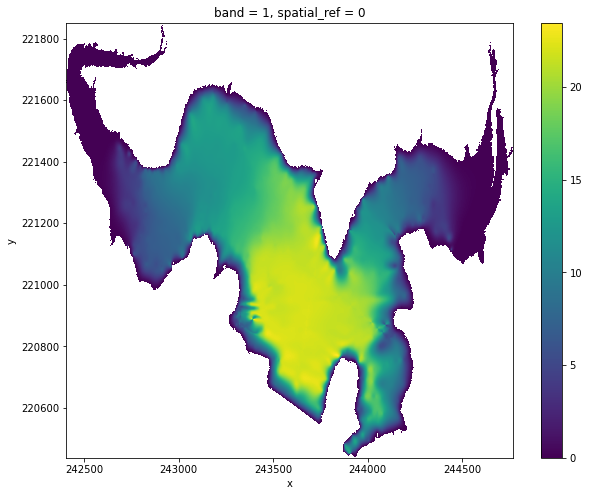

In [3]:
_, ax = plt.subplots(1, 1, figsize=standard_fig_size)
patillas_bathy.plot(ax=ax)
plt.show()

The Lago Patillas raster uses a local projections (northings/eastings) instead of the geodesic reference system (latitude/longitude). I project the transform to WGS84 (EPSG:4326) to get the bounding box in latitude and longitude. I also set the timeframe for which I want to get observations. As the GEE API doesn't want me to load a lot of data I only specify one month (resulting in 7 overpasses).

In [4]:
wgs84 = pyproj.CRS('EPSG:4326')
left, bottom, right, top = patillas_bathy.rio.transform_bounds(wgs84)

latitude = (bottom, top)
longitude = (left, right)
time = ('2021-05-01', '2021-06-01')

I use the `display_map` utility (which has been taken from the [ODC example repos](https://github.com/opendatacube/datacube-notebooks/blob/master/utils/notebooks/display_map.py)) to see how the surveyed area would look like using Google's extremely high quality satellite true color images with folium. This is just for debugging.

In [43]:
from display_map import display_map
display_map(latitude, longitude)

The datacube API (if used in combination with GEE realtime indexing) needs to be called with a target CRS (for some reason only EPSG:4327 worked for me) which in turn makes the resolution mandatory. With EPSG:4326 the resolution has to be given in degrees. As different degree distances correspond to different meter distances depending on where on the globe two points are located we need to calculate the resolution we want to get depending on our survey object (Lago Patillas).

In [53]:
from geopy import distance

# this is just an example which should be in the region of 10s-ish meters
degree_resolution = 2.69493352e-4

upper_left_corner = left, top
upper_left_corner_with_offset = left + degree_resolution, top

distance_in_meters_coarse = distance.geodesic(upper_left_corner, upper_left_corner_with_offset).meters
distance_in_meters_coarse

30.050642713748175

In [54]:
factor_to_come_to_10_m = distance_in_meters_coarse / 10
degree_resolution_to_10_m = degree_resolution / factor_to_come_to_10_m

distance.geodesic(upper_left_corner, (left + degree_resolution_to_10_m, top)).meters

10.000000117722111

With all these preparations we can load the dataset. You will need to have access to Google Earth Engine for this. Depending on factors I have still to understand this might be pretty quick or take forever and fail.

In [46]:
dc = Datacube(app="odc-gee-exploration", config="../config/datacube.conf")
ds = dc.load(asset='COPERNICUS/S2_SR', measurements=["B4", "B3", "B2", "B8"],
             latitude=latitude,
             longitude=longitude,
             time=time,
             resolution=(-degree_resolution_to_10_m, degree_resolution_to_10_m),
             group_by="solar_day",
             output_crs="EPSG:4326")

In [47]:
ds

<xarray.Dataset>
Dimensions:      (time: 7, latitude: 144, longitude: 250)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-02T15:07:41.767000 ... 2021-06...
  * latitude     (latitude) float64 18.03 18.03 18.03 ... 18.02 18.02 18.02
  * longitude    (longitude) float64 -66.03 -66.03 -66.03 ... -66.01 -66.01
    spatial_ref  int32 4326
Data variables:
    B4           (time, latitude, longitude) uint16 252 252 265 ... 3584 3754
    B3           (time, latitude, longitude) uint16 537 523 514 ... 3836 4056
    B2           (time, latitude, longitude) uint16 218 210 207 ... 3906 4176
    B8           (time, latitude, longitude) uint16 3708 3506 3450 ... 4328 4576
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [48]:
ds.dims

Frozen({'time': 7, 'latitude': 144, 'longitude': 250})

By pure chance the first image is pretty good (only a minimal amount of clouds).

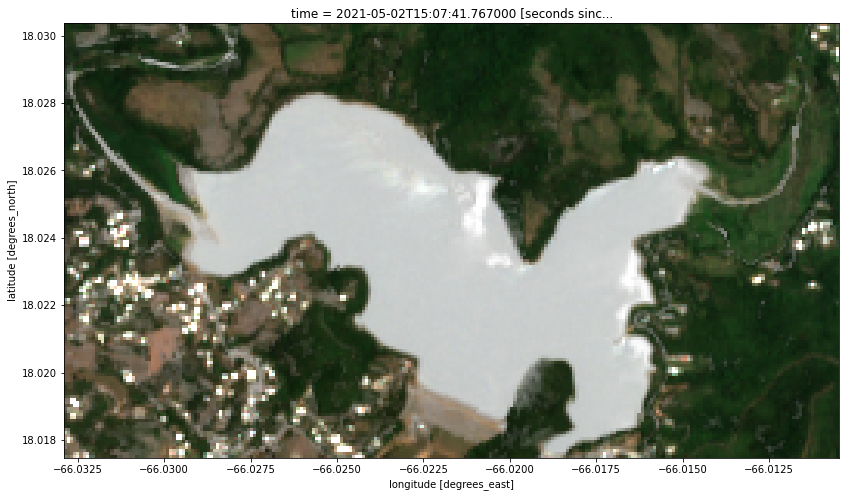

In [49]:
ds.isel(time=0).to_array().plot.imshow(vmin=0, vmax=3000, size=8,
                                       aspect=ds.dims['longitude']/ds.dims['latitude'])

Taking the median pixel values is unfortunately far worse than the trivial "look at the first picture"-solution. Sentinel-2A data products would have a band with existing classification results telling us if a pixel (60x60m) contains clouds. If you could load a lot more data we could filter out all cloudy pixels and then try mean/median again. Unfortunately I won't manage to do this with this setup. I will try again using the [AWS Landsat-2 Cloud Optimizes geoTIFFs](https://registry.opendata.aws/sentinel-2-l2a-cogs/) spatio temporal asset catalog (STAC).

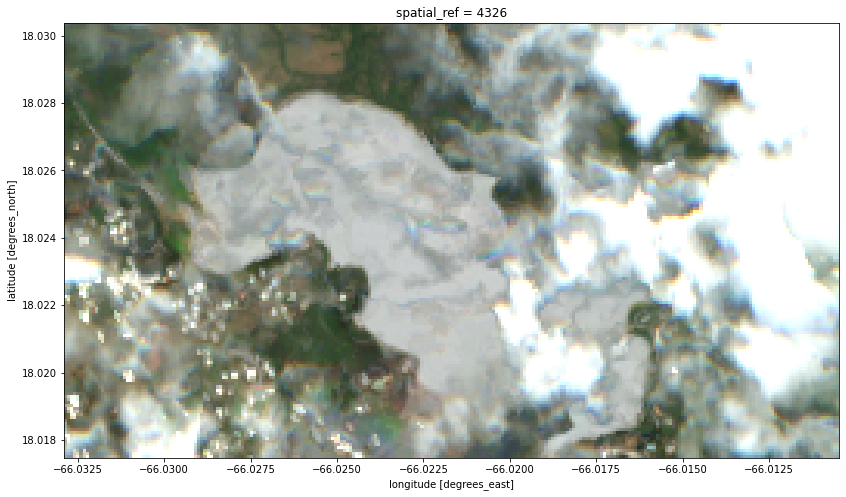

In [52]:
ds.median(dim="time").to_array().plot.imshow(vmin=0, vmax=3000, size=8,
                                             aspect=ds.dims['longitude']/ds.dims['latitude'])